In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from datetime import *
from imu_video_synch import *
from zurich_move_data_extraction import *
from utilities import *
from activity_count_function import *
from individual_analysis_ac_functions import *
from group_analysis_functions import *
from test_48h_dataset import *

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [14]:
import os

# CHANGE VALUES HERE #
non_affected_hand = 'right'
affected_hand = 'left'
participant_id = 'FHT002'
start_date = '2023-05-08 15:00:00.000'
end_date = '2023-05-10 14:30:00.000'

# Dynamic path creation
initial_path = os.path.join("X:", "ZM data DB study", participant_id, "T0")

imu_path = os.path.join(initial_path, 'jumpExp_230508_150212.mat')

# Testing
figures_path = '../CreateStudy/figures'
testing_figures_path = os.path.join(figures_path, f"testing_{participant_id}")
# Invoke the create_folder function to create the directory
create_folder(testing_figures_path)

In [15]:
imu_path

'X:ZM data DB study\\FHT002\\T0\\jumpExp_230508_150212.mat'

In [16]:
# Define the sensor placements, sensor features, and dataframe features
sensor_placement = ['LW', 'RW', 'chest']
matlab_sensor_features = ['acc', 'gyro', 'quat', 'accHiG', 'magneto', 'press']
sensor_features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_0', 'quat_1', 'quat_2',
                   'quat_3', 'accHiG_x', 'accHiG_y', 'accHiG_z', 'magneto_x', 'magneto_y', 'magneto_z', 'press']
sensor_9DOF_features = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ',
                       'magnetoX', 'magnetoY', 'magnetoZ']
sensor_acc_features =  ['acc_x', 'acc_y', 'acc_z']

# Constants related to thresholds
conventional_functional_space = 30
conventional_threshold_unilateral = 2  # Bailey and Lang, 2013
conventional_threshold_bilateral = 0  # Bailey and Lang, 2013

# Constants related to metric frequencies
frequency_GT = 50  # Hz
frequency_gm = 2   # Hz
frequency_gmac = 1  # Hz

In [17]:
# Load Optimal Helathy Group Thresholds 
initial_path = '../CreateStudy'
ac_threshold_file = 'H_optimal_threshold_AC.csv'
fs_threshold_file = 'H_optimal_threshold_GM.csv'
ac_threshold_path = os.path.join(initial_path, ac_threshold_file)
fs_threshold_path = os.path.join(initial_path, fs_threshold_file)
group_optimal_AC_NDH, group_optimal_AC_DH = load_threshold_from_csv(ac_threshold_path)
group_optimal_FS_NDH, group_optimal_FS_DH = load_threshold_from_csv(fs_threshold_path)
print(group_optimal_AC_NDH, group_optimal_AC_DH, group_optimal_FS_NDH, group_optimal_FS_DH)

10.08 17.04 53 51


In [18]:
# Create a dict to save data on the participant 
participant_dataset = {
    'participant_id': participant_id,
    'affected_hand':affected_hand
}

In [8]:
trimmed_LW_data, trimmed_RW_data = load_or_generate_data(initial_path, imu_path)

Trimmed datasets not found. Extracting and preparing data.


In [9]:
trimmed_LW_data, trimmed_RW_data

(0, 0)

In [10]:
# Full extraction 
header = extract_header_data_from_mat_file(imu_path)
sampling_freq =get_sampling_freq(header)
time_array = extract_time_data_from_mat_file(imu_path)
recording_time = get_recording_time(time_array)
dfs = extract_sensors_data_from_mat_file_48h(imu_path, sensor_placement, matlab_sensor_features, sensor_features, num_sensors = 2)
acc_LW = dfs['LW'][['acc_x', 'acc_y', 'acc_z']]
acc_RW = dfs['RW'][['acc_x', 'acc_y', 'acc_z']]
gyro_LW = dfs['LW'][['gyro_x', 'gyro_y', 'gyro_z']]
gyro_RW = dfs['RW'][['gyro_x', 'gyro_y', 'gyro_z']]
mag_LW = dfs['LW'][['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_LW = dfs['LW'][['quat_0', 'quat_1', 'quat_2','quat_3']]
LW_data = dfs['LW']
RW_data = dfs['RW']
chest_data = dfs['chest']
# Returning the untrimmed LW_data and RW_data, which can be trimmed later in your notebook

In [19]:
header

,durationStr,freq,start,startStr,stop,stopStr,tsErrorSensorIDs
0,1 d   2 3 h   3 0 m   5 6 s ,50.0,1.683558e+09,2 0 2 3 / 0 5 / 0 8   1 5 : 0 2 : 1 2 . 0 0 0 ,1.683729e+09,2 0 2 3 / 0 5 / 1 0   1 4 : 3 3 : 0 8 . 0 0 0 ,                


In [20]:
RW_data

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_0,quat_1,quat_2,quat_3,accHiG_x,accHiG_y,accHiG_z,magneto_x,magneto_y,magneto_z,press
0,-0.607974,0.179838,-3.069306,134.915186,-140.806639,148.871111,0.778260,-0.395340,0.355862,-0.333744,-0.557912,0.281099,-1.837432,173.394940,113.403630,-148.789605,1012.510000
1,-0.801891,0.267116,-2.969125,156.882538,-140.620750,160.052781,0.804424,-0.374466,0.340524,-0.310999,-0.595985,0.259645,-1.917079,173.418919,113.386428,-148.838865,1012.510000
2,-1.054239,0.336142,-2.855384,182.660644,-152.714731,170.705784,0.831721,-0.348697,0.322942,-0.286977,-0.661290,0.261664,-1.873350,173.329267,113.450743,-148.654689,1012.510000
3,-1.215281,0.344943,-2.866912,209.865108,-151.407782,170.681731,0.859144,-0.318150,0.302782,-0.262627,-0.759415,0.228664,-1.795015,173.664459,113.210279,-149.343291,1012.510000
4,-1.378210,0.413095,-2.735685,235.949831,-123.091204,150.001216,0.884255,-0.282071,0.282748,-0.242020,-0.872435,0.339540,-1.808394,172.411238,114.109329,-146.768739,1012.510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552796,0.852806,1.571752,-0.713747,52.761757,-29.949443,62.161725,-0.397693,-0.199649,0.850422,0.280650,0.204101,0.970721,-0.629006,122.744434,349.841492,44.293182,1012.179703
8552797,0.823569,1.573380,-0.836627,66.129052,-50.930216,90.819786,-0.392755,-0.190044,0.858970,0.267947,0.176021,0.929112,-0.629117,117.740907,345.983350,48.995292,1012.192765
8552798,1.020515,1.453484,-1.129172,79.802916,-51.705546,112.686854,-0.386944,-0.176955,0.869268,0.251661,0.028636,0.979345,-0.581800,119.084367,347.019271,47.732764,1012.189258
8552799,1.402947,1.295723,-1.110896,80.682234,-34.406728,116.805335,-0.383650,-0.162979,0.878739,0.232528,0.007547,0.979569,-0.662311,118.723648,346.741126,48.071752,1012.190199


In [21]:
# Add timestamps 
IMU_start_timestamp, IMU_end_timestamp = get_datetime_timestamp(header)

2023-05-08 15:02:12.000000 2023-05-10 14:33:08.000000


In [22]:
timestamps_array = create_timestamps(IMU_start_timestamp, IMU_end_timestamp, 50)
# Add timestamps to raw data
LW_data = pd.concat([timestamps_array, LW_data], axis=1)
RW_data = pd.concat([timestamps_array, RW_data], axis=1)
chest_data = pd.concat([timestamps_array, chest_data], axis=1)

In [23]:
RW_data

,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_0,quat_1,quat_2,quat_3,accHiG_x,accHiG_y,accHiG_z,magneto_x,magneto_y,magneto_z,press
0,2023-05-08 15:02:12.000,-0.607974,0.179838,-3.069306,134.915186,-140.806639,148.871111,0.778260,-0.395340,0.355862,-0.333744,-0.557912,0.281099,-1.837432,173.394940,113.403630,-148.789605,1012.510000
1,2023-05-08 15:02:12.020,-0.801891,0.267116,-2.969125,156.882538,-140.620750,160.052781,0.804424,-0.374466,0.340524,-0.310999,-0.595985,0.259645,-1.917079,173.418919,113.386428,-148.838865,1012.510000
2,2023-05-08 15:02:12.040,-1.054239,0.336142,-2.855384,182.660644,-152.714731,170.705784,0.831721,-0.348697,0.322942,-0.286977,-0.661290,0.261664,-1.873350,173.329267,113.450743,-148.654689,1012.510000
3,2023-05-08 15:02:12.060,-1.215281,0.344943,-2.866912,209.865108,-151.407782,170.681731,0.859144,-0.318150,0.302782,-0.262627,-0.759415,0.228664,-1.795015,173.664459,113.210279,-149.343291,1012.510000
4,2023-05-08 15:02:12.080,-1.378210,0.413095,-2.735685,235.949831,-123.091204,150.001216,0.884255,-0.282071,0.282748,-0.242020,-0.872435,0.339540,-1.808394,172.411238,114.109329,-146.768739,1012.510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552796,2023-05-10 14:33:07.920,0.852806,1.571752,-0.713747,52.761757,-29.949443,62.161725,-0.397693,-0.199649,0.850422,0.280650,0.204101,0.970721,-0.629006,122.744434,349.841492,44.293182,1012.179703
8552797,2023-05-10 14:33:07.940,0.823569,1.573380,-0.836627,66.129052,-50.930216,90.819786,-0.392755,-0.190044,0.858970,0.267947,0.176021,0.929112,-0.629117,117.740907,345.983350,48.995292,1012.192765
8552798,2023-05-10 14:33:07.960,1.020515,1.453484,-1.129172,79.802916,-51.705546,112.686854,-0.386944,-0.176955,0.869268,0.251661,0.028636,0.979345,-0.581800,119.084367,347.019271,47.732764,1012.189258
8552799,2023-05-10 14:33:07.980,1.402947,1.295723,-1.110896,80.682234,-34.406728,116.805335,-0.383650,-0.162979,0.878739,0.232528,0.007547,0.979569,-0.662311,118.723648,346.741126,48.071752,1012.190199


In [24]:
# Trim dataset
trimmed_LW_data = trim_dataframe_by_time(LW_data, start_date, end_date)

In [25]:
trimmed_LW_data

,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_0,quat_1,quat_2,quat_3,accHiG_x,accHiG_y,accHiG_z,magneto_x,magneto_y,magneto_z,press
0,2023-05-08 15:02:12.000,1.509160,-0.655014,-1.189763,11.479387,-156.748620,-12.445088,0.899896,0.026069,-0.225125,-0.372616,0.524481,0.104289,0.156147,168.001137,204.602456,26.997134,1022.021120
1,2023-05-08 15:02:12.020,1.367969,-0.570226,-1.344546,29.943293,-193.690443,-23.881872,0.890682,0.018076,-0.256758,-0.374732,0.632077,0.004428,0.097230,167.999698,204.599347,27.000762,1022.019702
2,2023-05-08 15:02:12.040,1.048868,-0.353936,-1.311248,-7.640245,-167.209908,-33.048753,0.879802,0.008296,-0.286365,-0.379314,0.591428,0.038624,0.101597,168.000080,204.600174,26.999797,1022.020079
3,2023-05-08 15:02:12.060,0.908856,-0.316410,-1.302929,-30.748843,-130.743615,-1.080074,0.870871,-0.004842,-0.308763,-0.382389,0.498960,0.187401,0.005335,167.999979,204.599952,27.000054,1022.019979
4,2023-05-08 15:02:12.080,1.124889,-0.440182,-1.299954,-65.703354,-75.230243,12.442877,0.865998,-0.020183,-0.320426,-0.383367,0.346778,0.199396,-0.000914,168.000003,204.600018,26.999987,1022.020006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8543396,2023-05-10 14:29:59.920,-0.441266,-0.461036,-1.803901,-9.092309,-1.364887,-10.264690,0.250693,-0.939904,-0.206837,0.104651,-0.002464,0.040443,-0.013649,189.000007,31.200011,25.800003,1005.700000
8543397,2023-05-10 14:29:59.940,0.004851,-0.725546,-1.811894,-9.661334,6.429676,-15.610045,0.249565,-0.940283,-0.207564,0.102475,-0.218587,0.007651,-0.197932,188.999997,31.199992,25.799990,1005.700000
8543398,2023-05-10 14:29:59.960,-0.120902,-0.913931,-1.996064,-24.733602,-14.883932,-11.487914,0.246479,-0.940338,-0.211074,0.102277,-0.280211,0.093749,-0.093380,189.000005,31.200021,25.800038,1005.700000
8543399,2023-05-10 14:29:59.980,-0.101307,-0.808767,-1.523352,-15.759339,-23.578782,-18.076531,0.241927,-0.940634,-0.214308,0.103688,-0.086400,-0.062819,-0.149803,188.999983,31.199924,25.799857,1005.700000


In [26]:
trimmed_RW_data = trim_dataframe_by_time(RW_data, start_date, end_date)

In [27]:
trimmed_RW_data

,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,quat_0,quat_1,quat_2,quat_3,accHiG_x,accHiG_y,accHiG_z,magneto_x,magneto_y,magneto_z,press
0,2023-05-08 15:02:12.000,-0.607974,0.179838,-3.069306,134.915186,-140.806639,148.871111,0.778260,-0.395340,0.355862,-0.333744,-0.557912,0.281099,-1.837432,173.394940,113.403630,-148.789605,1012.510000
1,2023-05-08 15:02:12.020,-0.801891,0.267116,-2.969125,156.882538,-140.620750,160.052781,0.804424,-0.374466,0.340524,-0.310999,-0.595985,0.259645,-1.917079,173.418919,113.386428,-148.838865,1012.510000
2,2023-05-08 15:02:12.040,-1.054239,0.336142,-2.855384,182.660644,-152.714731,170.705784,0.831721,-0.348697,0.322942,-0.286977,-0.661290,0.261664,-1.873350,173.329267,113.450743,-148.654689,1012.510000
3,2023-05-08 15:02:12.060,-1.215281,0.344943,-2.866912,209.865108,-151.407782,170.681731,0.859144,-0.318150,0.302782,-0.262627,-0.759415,0.228664,-1.795015,173.664459,113.210279,-149.343291,1012.510000
4,2023-05-08 15:02:12.080,-1.378210,0.413095,-2.735685,235.949831,-123.091204,150.001216,0.884255,-0.282071,0.282748,-0.242020,-0.872435,0.339540,-1.808394,172.411238,114.109329,-146.768739,1012.510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8543396,2023-05-10 14:29:59.920,-0.855081,0.088140,-2.190183,0.728490,-0.303056,-0.417769,-0.146894,-0.655140,-0.732223,0.114294,-0.730421,0.213222,-1.420393,267.000258,228.600086,-3.000086,1011.320006
8543397,2023-05-10 14:29:59.940,-0.853124,0.074575,-2.174700,-0.125829,-0.806867,-0.091320,-0.146953,-0.655121,-0.732215,0.114373,-0.795805,0.184116,-1.411835,266.999036,228.599679,-2.999679,1011.319979
8543398,2023-05-10 14:29:59.960,-0.838704,0.050546,-2.159475,0.143358,-0.277461,-0.160030,-0.147004,-0.655105,-0.732209,0.114446,-0.751755,0.233419,-1.420077,267.003598,228.601199,-3.001199,1011.320080
8543399,2023-05-10 14:29:59.980,-0.849121,0.069562,-2.152559,-0.187425,-0.237509,0.040040,-0.146984,-0.655104,-0.732214,0.114441,-0.727477,0.191089,-1.388424,266.986566,228.595522,-2.995522,1011.319701


In [28]:
# Save the trimmed dataset to avoid having to redo the trimming operation 
# Use Feather package to be more efficient   
save_dataframe_feather(trimmed_LW_data, initial_path, "trimmed_LW_data")
save_dataframe_feather(trimmed_RW_data, initial_path, "trimmed_RW_data")

DataFrame saved at ../CreateStudy\trimmed_LW_data.feather


OSError: [Errno 28] Error writing bytes to file. Detail: [errno 28] No space left on device

In [29]:
# COMPUTATION # 

In [32]:
if affected_hand.lower() == 'right': 
    ndh_data = trimmed_RW_data
    dh_data = trimmed_LW_data
else: 
    ndh_data = trimmed_LW_data
    dh_data = trimmed_RW_data

In [33]:
# Get useful variables
sampling_freq = 50
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz

In [34]:
#Compute Brond Actigraph Activity Count 
count_brond_ndh, processed_data_ndh = get_counts_brond(ndh_data)
count_brond_dh, processed_data_dh = get_counts_brond(dh_data)
AC_ndh = np.array(count_brond_ndh['AC Brond'])
AC_dh = np.array(count_brond_dh['AC Brond'])

In [35]:
# Update the participant JSON file with new arrays of usefull data  
# Add Brond AC 
add_attributes_to_participant(participant_dataset, AC_NDH = AC_ndh, AC_DH = AC_dh)

In [36]:
participant_dataset

{'participant_id': 'FHT002',
 'affected_hand': 'left',
 'AC_NDH': array([358.17035053, 313.51714467,  57.00877125, ..., 196.33135256,
        268.73034812, 142.46754016]),
 'AC_DH': array([441.48159645, 222.22961099, 429.121195  , ...,   0.        ,
          0.        ,   0.        ])}

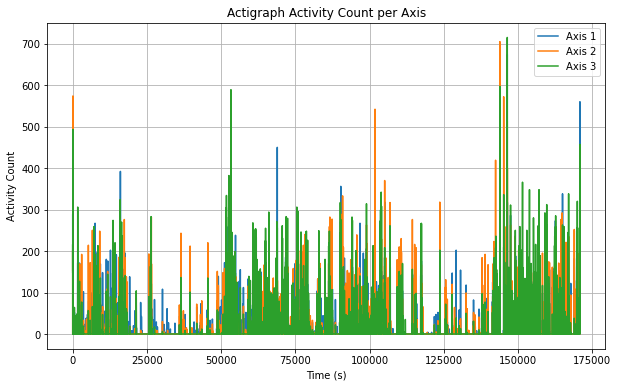

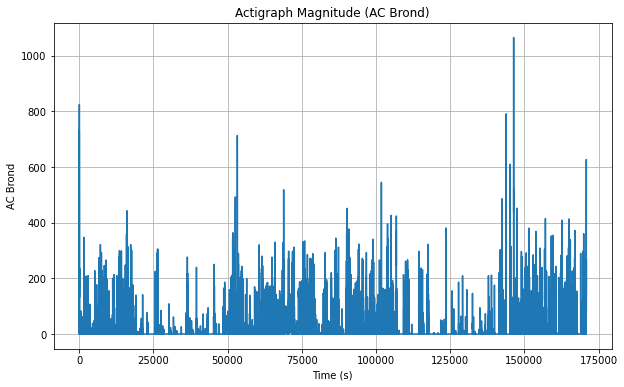

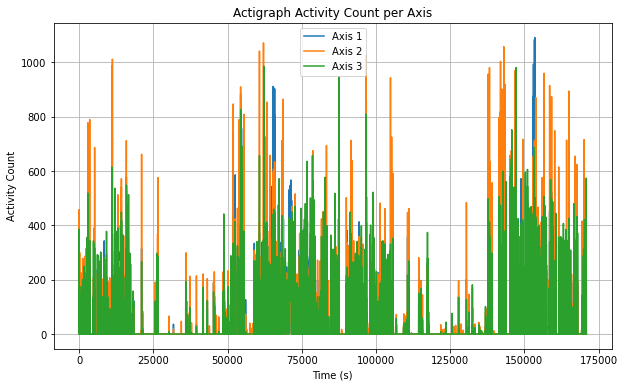

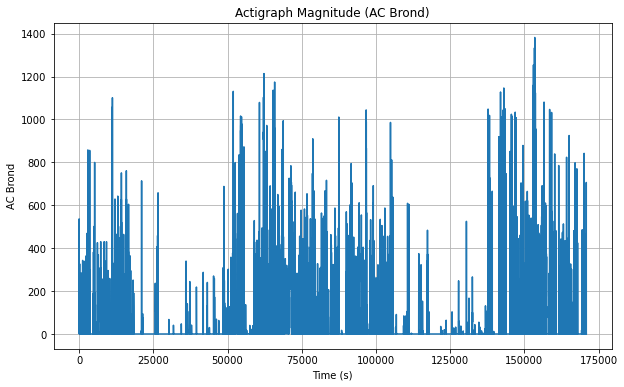

(None, None)

In [37]:
plot_actigraph_count(count_brond_ndh), plot_actigraph_count(count_brond_dh)

In [38]:
# Laterality metrics #

In [39]:
# Bilateral Magnitude 
bilateral_magnitude = compute_bilateral_magnitude(AC_ndh, AC_dh)
magnitude_ratio = get_magnitude_ratio(AC_ndh, AC_dh)

In [40]:
testing_figures_path

'../CreateStudy/figures\\testing_FHT002'

Figure saved as '../CreateStudy/figures\testing_FHT002\ratio_distribution.png'


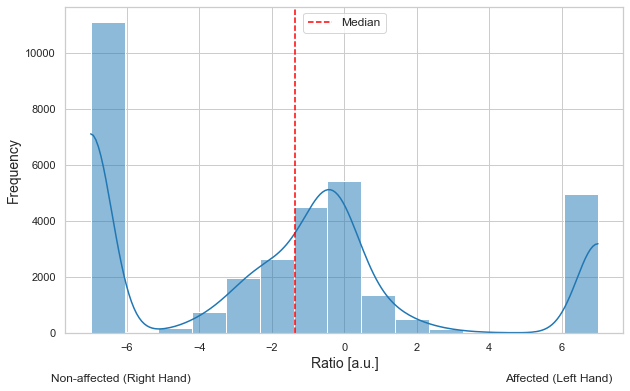

Figure saved as '../CreateStudy/figures\testing_FHT002\density_plot.png'


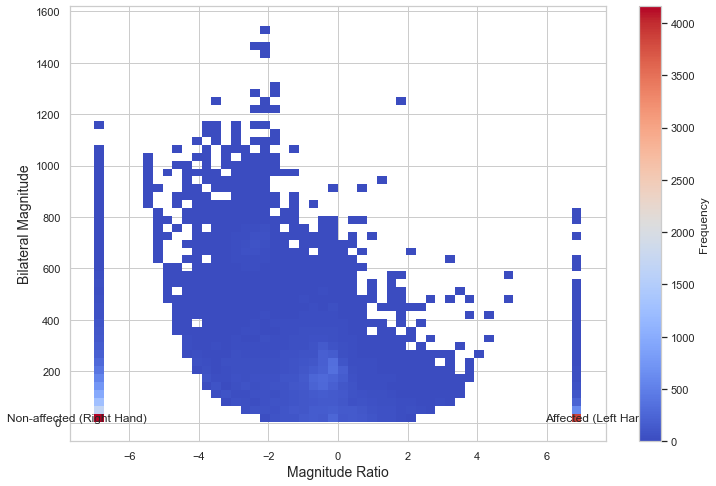

In [41]:
plot_distribution_ratio(magnitude_ratio, non_affected_hand = non_affected_hand, saving_path = testing_figures_path)
plot_density(bilateral_magnitude, magnitude_ratio, non_affected_hand = non_affected_hand, saving_path = testing_figures_path)

In [42]:
## GM Algorithm Computation ##

In [43]:
# Get Euler angles usign Madgwick sensor fusiona algorithm 
# Left wrist
roll_mad_ndh, pitch_mad_ndh, yaw_mad_ndh = compute_euler_angles(acc_ndh, gyro_ndh, sampling_freq)
# Right wrist 
roll_mad_dh, pitch_mad_dh, yaw_mad_dh = compute_euler_angles(acc_dh, gyro_dh, sampling_freq)

Using IMU Madgwick with acc and gyro only
Using IMU Madgwick with acc and gyro only


In [44]:
# Add Euler angles to participant dataset 
add_attributes_to_participant(participant_dataset, pitch_NDH = pitch_mad_ndh, yaw_NDH = yaw_mad_ndh,
                              pitch_DH = pitch_mad_dh, yaw_DH = yaw_mad_dh)

In [45]:
# Save the JSON file of the participant 
save_to_json(participant_dataset, initial_path)

OSError: [Errno 28] No space left on device

In [46]:
# TESTING PART# 

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [47]:
# Create a dict to store all the thresholds: optimal and conventional 
thresholds = {
    'group_AC_NDH': group_optimal_AC_NDH,
    'group_AC_DH': group_optimal_AC_DH,
    'group_optimal_FS_NDH': group_optimal_FS_NDH,
    'group_optimal_FS_DH': group_optimal_FS_DH,
    'conventional_AC_threshold_unilateral': conventional_threshold_unilateral,
    'conventional_AC_threshold_bilateral': conventional_threshold_bilateral,
    'conventional_functional_space': conventional_functional_space
}

In [48]:
# Create a random GT just for the function to work
GT_mask_NDH_1Hz = np.zeros_like(AC_ndh)
GT_mask_DH_1Hz = np.zeros_like(AC_dh)
GT_mask_NDH_2Hz = np.zeros_like(AC_ndh)
GT_mask_DH_2Hz = np.zeros_like(AC_dh)
GT_mask_NDH_25Hz = np.zeros_like(AC_ndh)
GT_mask_DH_25Hz = np.zeros_like(AC_dh)
# Add to the participant dataset 
add_attributes_to_participant(participant_dataset, GT_mask_NDH_1Hz = GT_mask_NDH_1Hz, GT_mask_DH_1Hz = GT_mask_DH_1Hz, 
                             GT_mask_NDH_2Hz = GT_mask_NDH_2Hz, GT_mask_DH_2Hz = GT_mask_DH_2Hz, 
                             GT_mask_NDH_25Hz = GT_mask_NDH_25Hz, GT_mask_DH_25Hz = GT_mask_DH_25Hz)

In [49]:
testing_dict_GT = get_GT_dict(participant_dataset)

In [50]:
# Test new optimal AC Threshold values on unseen data using the testing participant 
ac_scores, _ = compute_evaluation_metrics(participant_dataset, thresholds, metric = 'AC')

C:\Users\Pierre-Louis\Documents\SEC\ZurichMove\utilities.py:535: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = true_positives / (true_positives + false_negatives)


In [51]:
# Test new optimal FS values on unseen data using the testing participant 
gm_scores, _ = compute_evaluation_metrics(participant_dataset, thresholds, metric = 'GM')

In [52]:
# GMAC
gmac_scores, _ = compute_evaluation_metrics(participant_dataset, thresholds, metric = 'GMAC')

In [53]:
# Add UL algo scores to the participant dataset 
add_attributes_to_participant(participant_dataset, ac_scores = ac_scores, gm_scores = gm_scores, gmac_scores = gmac_scores)

In [54]:
# Save the JSON file of the participant 
#save_to_json(participant_dataset, initial_path)

OSError: [Errno 28] No space left on device

In [55]:
# Compare Duration of arm use # 
# Compute duration of functional arm use on testing dataset
# Get duration of arm use and corresponding % 
gmac_duration_arm_use = get_duration_functional_arm_use(gmac_scores, sampling_frequency = frequency_gmac)
ac_duration_arm_use = get_duration_functional_arm_use(ac_scores, sampling_frequency = frequency_gmac)
gm_duration_arm_use = get_duration_functional_arm_use(gm_scores, sampling_frequency = frequency_gm)
GT_50Hz_duration_arm_use = get_duration_functional_arm_use(testing_dict_GT, sampling_frequency = frequency_GT)

In [56]:
gm_duration_arm_use

{'ndh': {'conv': {'percentage_active': 0.30023087930191933,
   'duration_formatted': '00:08:33'},
  'opt': {'percentage_active': 0.9507311177894112,
   'duration_formatted': '00:27:04'}},
 'dh': {'conv': {'percentage_active': 4.1008143689445395,
   'duration_formatted': '01:56:47'},
  'opt': {'percentage_active': 5.434881209819247,
   'duration_formatted': '02:34:46'}},
 'bil': {'conv': {'percentage_active': 0.07257042696576607,
   'duration_formatted': '00:02:04'},
  'opt': {'percentage_active': 0.4292774853176566,
   'duration_formatted': '00:12:13'}}}

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_NDH_AC.png'


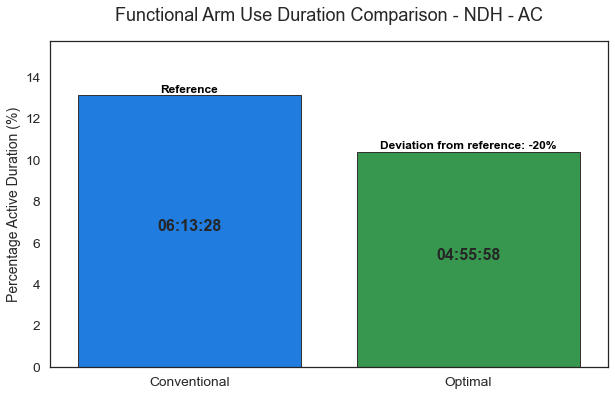

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_DH_AC.png'


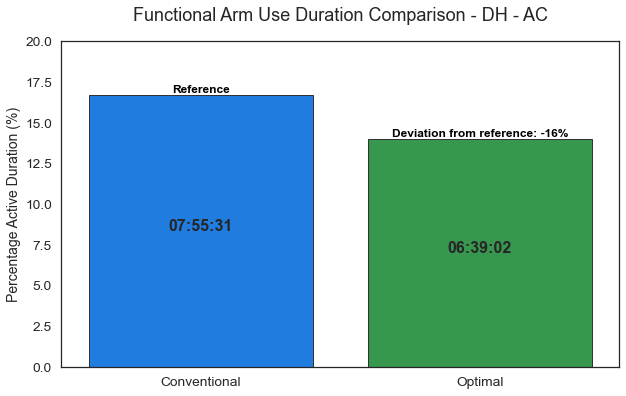

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_BIL_AC.png'


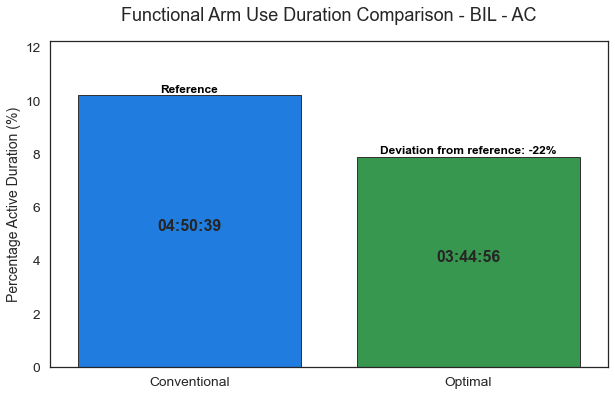

In [57]:
compare_arm_use_duration_plot_48h(ac_duration_arm_use, 'AC', save_path = testing_figures_path)

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_NDH_GM.png'


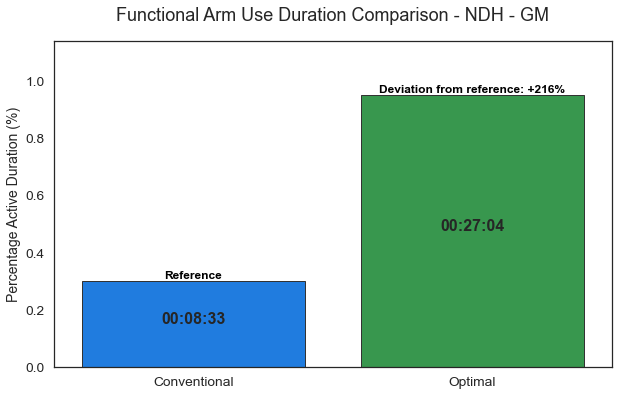

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_DH_GM.png'


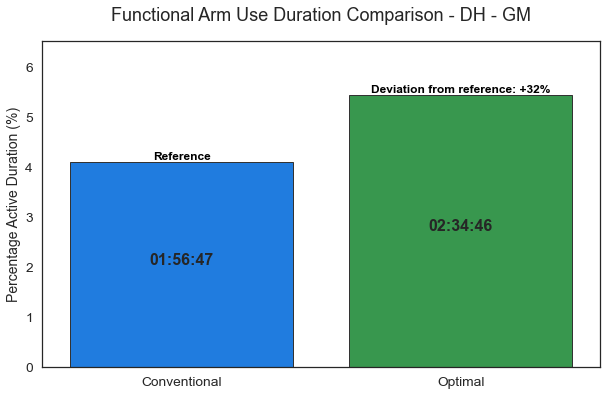

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_BIL_GM.png'


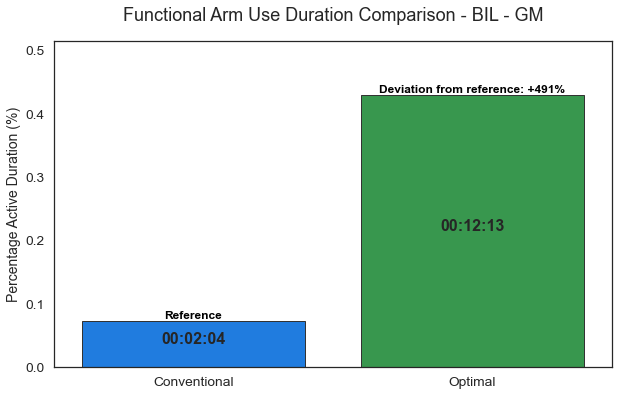

In [58]:
compare_arm_use_duration_plot_48h(gm_duration_arm_use, 'GM', save_path = testing_figures_path)

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_NDH_GMAC.png'


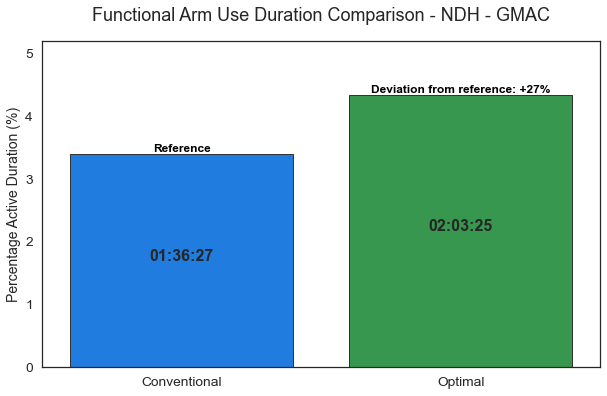

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_DH_GMAC.png'


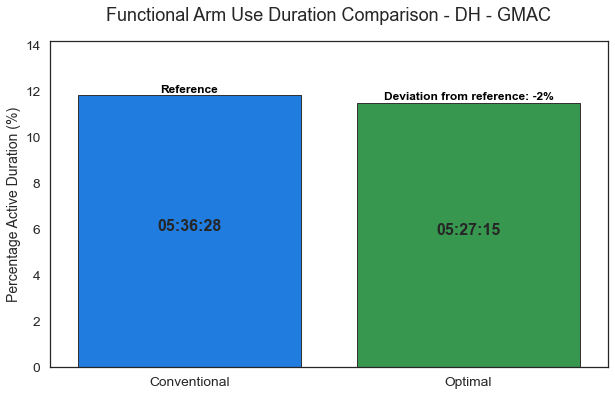

Figure saved as '../CreateStudy/figures\testing_FHT002\Functional_Arm_Use_Duration_Comparison_BIL_GMAC.png'


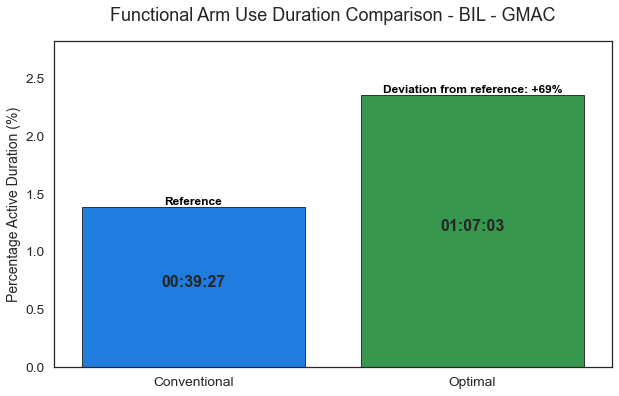

In [60]:
compare_arm_use_duration_plot_48h(gmac_duration_arm_use, 'GMAC', save_path = testing_figures_path)